<a href="https://colab.research.google.com/github/anggitwr/LeavesImage-Classification/blob/main/vgg19_dari_16_label_Klasifikasi_tanaman_ep35.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os
from matplotlib import image, pyplot
import pandas as pd
from google.colab import drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip Compress File
zip_file_path = "./drive/MyDrive/klasifikasi/DATASET TANAMAN HERBAL4.zip"  # Replace with the actual path to your ZIP file
destination_dir = "./data/"  # Replace with the desired path to create the directory

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Extract the contents of the ZIP file to the destination directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

In [ ]:
# Declaration file location
sdir = './data/DATASET TANAMAN HERBAL4/Data Training/'
labels = os.listdir(sdir)

In [ ]:
filepaths=[]
labels=[]
classlist=os.listdir(sdir)
for klass in classlist:
    classpath=os.path.join(sdir,klass)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths      labels
0  ./data/DATASET TANAMAN HERBAL4/Data Training/D...  Daun Sirih
1  ./data/DATASET TANAMAN HERBAL4/Data Training/D...  Daun Sirih
2  ./data/DATASET TANAMAN HERBAL4/Data Training/D...  Daun Sirih
3  ./data/DATASET TANAMAN HERBAL4/Data Training/D...  Daun Sirih
4  ./data/DATASET TANAMAN HERBAL4/Data Training/D...  Daun Sirih
Daun Kemangi       169
Teh Hijau          168
Daun Sirsak        158
Lidah Buaya        155
Daun Kunyit        154
Daun Jambu Biji    154
Daun Mint          151
Kaca               146
Plastik            144
Kain               142
Daun Pepaya        140
Daun Sirih         136
Daun Kari          136
Kertas             136
Besi               131
Kardus             112
Name: labels, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten,Input
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
# from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import seaborn as sns
sns.set_style('darkgrid')
# from sklearn.metrics import confusion_matrix, classification_report
# from IPython.display import display, HTML
from keras.callbacks import EarlyStopping
# from tensorflow.keras.optimizers import RMSprop

In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  1865   test_df length:  233   valid_df length:  234


In [ ]:
height=224
width=224
channels=3
batch_size=64

img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)

gen=ImageDataGenerator(rescale=1./255,
                       horizontal_flip=True,
                       vertical_flip=True,
                       rotation_range=50,
                       width_shift_range=0.1,
                       height_shift_range=0.1,
                       fill_mode='reflect',
                       brightness_range=(0.8,1.2),
                       zoom_range=0.2,
                      )
train_gen=gen.flow_from_dataframe( train_df,
                                  x_col='filepaths',
                                  y_col='labels',
                                  target_size=img_size,
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=True,
                                  batch_size=batch_size)

validgen=ImageDataGenerator(rescale=1./255,
                            horizontal_flip=True,
                            vertical_flip=True,
                           )
valid_gen=validgen.flow_from_dataframe( valid_df,
                                       x_col='filepaths',
                                       y_col='labels',
                                       target_size=img_size,
                                       class_mode='categorical',
                                       color_mode='rgb',
                                       shuffle=True,
                                       batch_size=batch_size)

testgen=ImageDataGenerator(rescale=1./255,
                          shear_range=0.2,
                          zoom_range=0.1,
                          horizontal_flip=True,
                          )
test_gen=testgen.flow_from_dataframe( test_df,
                                     x_col='filepaths',
                                     y_col='labels',
                                     target_size=img_size,
                                     class_mode='categorical',
                                     color_mode='rgb',
                                     shuffle=False,
                                     batch_size=test_batch_size)

classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)

test batch size:  1   test steps:  233
Found 1859 validated image filenames belonging to 16 classes.
Found 233 validated image filenames belonging to 16 classes.
Found 232 validated image filenames belonging to 16 classes.
['Besi', 'Daun Jambu Biji', 'Daun Kari', 'Daun Kemangi', 'Daun Kunyit', 'Daun Mint', 'Daun Pepaya', 'Daun Sirih', 'Daun Sirsak', 'Kaca', 'Kain', 'Kardus', 'Kertas', 'Lidah Buaya', 'Plastik', 'Teh Hijau']


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 6 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def show_image_samples(gen):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<20:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()

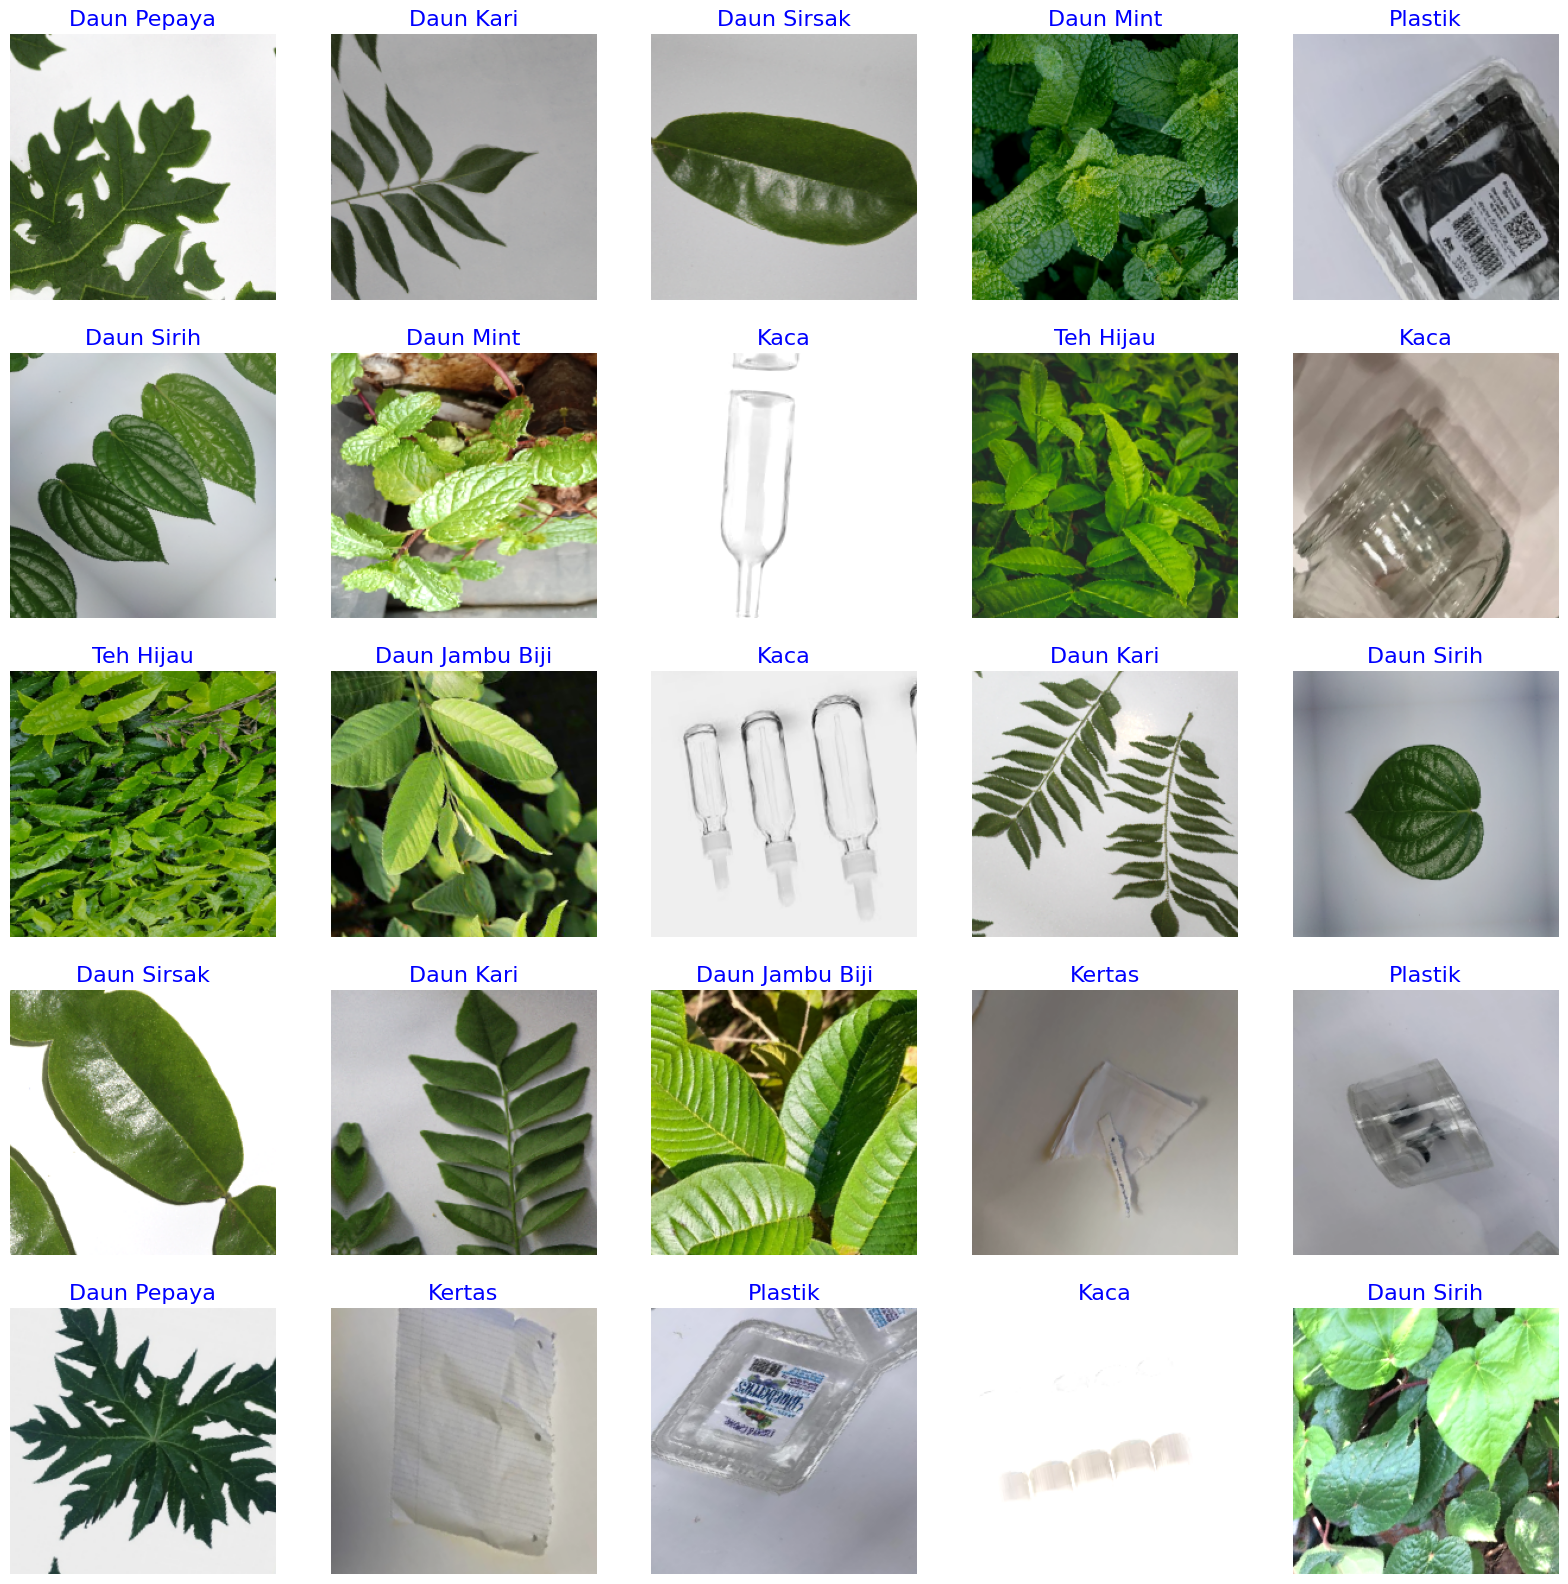

In [ ]:
show_image_samples(train_gen)

In [ ]:
base_model=tf.keras.applications.VGG19(include_top=False, weights="imagenet",input_tensor=Input(shape=(224,224,3)))

80134624/80134624 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
base_model.trainable = False

In [ ]:
model_name= 'Anggit'
print("Building model with", base_model)
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Conv2D(filters=32,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Conv2D(filters=64,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.MaxPool2D(pool_size= 2, strides= 2),
    tf.keras.layers.Conv2D(filters=128,padding='same', kernel_size = 3, activation='relu', strides= 1),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(16, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=.001), loss='categorical_crossentropy', metrics='accuracy')

Building model with <keras.engine.functional.Functional object at 0x7f3b37477e50>


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          147488    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 3, 3, 64)          18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 3, 64)          36928     
                                                        

In [ ]:
epochs = 35
history = model.fit(x=train_gen, epochs = epochs, validation_data = valid_gen)

Epoch 1/35
30/30 [==============================] - 307s 10s/step - loss: 2.7135 - accuracy: 0.0834 - val_loss: 2.4432 - val_accuracy: 0.1931
Epoch 2/35
30/30 [==============================] - 286s 10s/step - loss: 2.2121 - accuracy: 0.1829 - val_loss: 1.9528 - val_accuracy: 0.2361
Epoch 3/35
30/30 [==============================] - 264s 9s/step - loss: 1.8370 - accuracy: 0.2867 - val_loss: 1.4454 - val_accuracy: 0.4206
Epoch 4/35
30/30 [==============================] - 261s 9s/step - loss: 1.5070 - accuracy: 0.4120 - val_loss: 1.2327 - val_accuracy: 0.4464
Epoch 5/35
30/30 [==============================] - 276s 9s/step - loss: 1.3797 - accuracy: 0.4637 - val_loss: 1.1665 - val_accuracy: 0.5150
Epoch 6/35
30/30 [==============================] - 262s 9s/step - loss: 1.3119 - accuracy: 0.4922 - val_loss: 1.0669 - val_accuracy: 0.5880
Epoch 7/35
30/30 [==============================] - 258s 9s/step - loss: 1.1238 - accuracy: 0.5627 - val_loss: 1.1822 - val_accuracy: 0.5236
Epoch 8/35


In [ ]:
def plot_loss_curves(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    #plot
    plt.plot(epochs, loss, label = 'training_loss')
    plt.plot(epochs, val_loss, label = 'val_loss')
    plt.title("Loss")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()

    plt.figure()
    plt.plot(epochs, accuracy, label = 'training_accuracy')
    plt.plot(epochs, val_accuracy, label = 'val_accuracy')
    plt.title("Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("value")
    plt.legend()

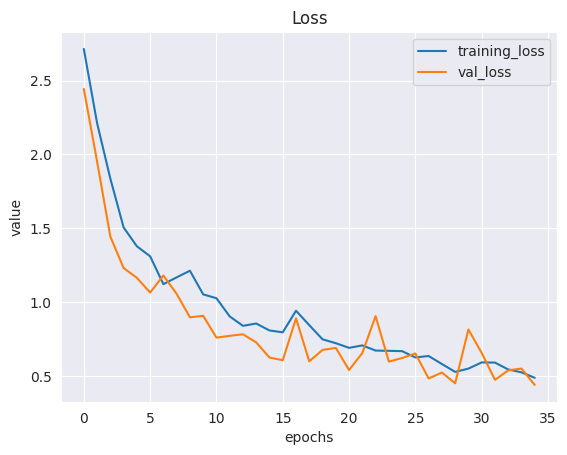

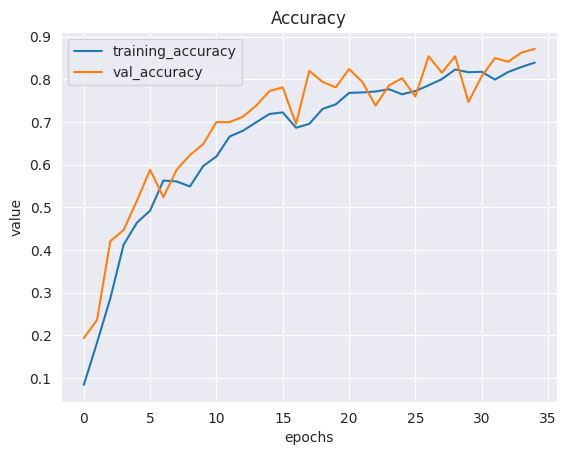

In [ ]:
plot_loss_curves(history)

In [ ]:
model.save('./drive/MyDrive/klasifikasi/modeldatalain16-4-epoch35-vgg19.h5')

In [ ]:
model.save('.modeldatalain16-4-epoch35-vgg19.h5')

In [ ]:
model = tf.keras.models.load_model('.modeldatalain16-4-epoch35-vgg19.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("converted16_30_vgg19_4.tflite", "wb").write(tflite_model)



20517368